# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model

# Load

In [2]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print(train_x.shape)
print(train_y.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
print(test_x.shape)
print(test_y.shape)

(10000, 32, 32, 3)
(10000, 1)


In [5]:
train_x = train_x.astype('float32')/255

In [6]:
test_x = test_x.astype('float32')/255

# Generating Noise

In [7]:
noise = np.random.normal(loc=0.0, scale=0.1, size=train_x.shape)
train_x_noise = train_x + noise
train_x_noise = np.clip(train_x_noise, 0., 1.)

In [8]:
noise = np.random.normal(loc=0.0, scale=0.1, size=test_x.shape)
test_x_noise = test_x + noise
test_x_noise = np.clip(test_x_noise, 0., 1.)

# Visualize

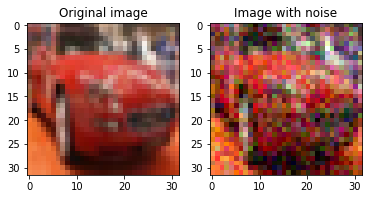

In [9]:
plt.subplot(1,2,1)
plt.imshow(train_x[5])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_x_noise[5])
plt.title('Image with noise')
plt.show()

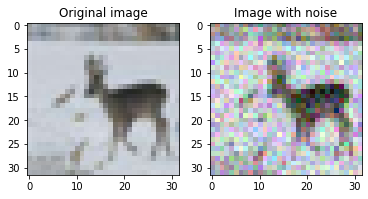

In [10]:
plt.subplot(1,2,1)
plt.imshow(train_x[20])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_x_noise[20])
plt.title('Image with noise')
plt.show()

# Using the autoencoder approach

In [11]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [12]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

**Model**

In [13]:
def denoising_autoencoder():
   den_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(den_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)
   den_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(den_inputs, den_outputs)

**Train**

In [14]:
model = denoising_autoencoder()
model.compile(loss='mse', optimizer='adam')
model.fit(train_x_noise,train_x,validation_data=(test_x_noise, test_x),epochs=35,batch_size=128)

Epoch 1/35
391/391 [==============================] - 13s 34ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 2/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 3/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 9/35
391/391 [==============================] - 12s 31ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/35
391/391 [==============================] - 12s 31ms/step - loss: 0.001

In [15]:
model.save('auto_model.h5')

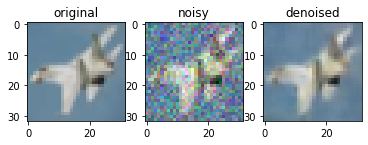

In [18]:
model.load_weights('auto_model.h5')
test_data_denoised = model.predict(test_x_noise)
idx = 10
plt.subplot(1,3,1)
plt.imshow(test_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_x_noise[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()